In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Input

In [2]:
def load_images(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))
    
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        if not os.path.isdir(class_path):
            continue
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(label)
    
    return np.array(images, dtype=object), np.array(labels)

In [3]:
# Paths
train_folder = "Animals Dataset/Train Data"
test_folder = "Animals Dataset/Test Data"

# Load
X_train, y_train = load_images(train_folder)
test_images, test_labels = load_images(test_folder)

In [4]:
# Debug info
print("Train images:", X_train.shape)
print("Train labels:", y_train.shape)

Train images: (2846,)
Train labels: (2846,)


In [5]:
print("A Train Image:", X_train[0].shape)
print("A Train label:", y_train[0].shape)

A Train Image: (375, 499, 3)
A Train label: ()


In [6]:
X_train = np.array([cv2.resize(img, (360, 360)) for img in X_train])

In [7]:
# X_train_resized = X_train_resized / 255.0

In [9]:
y_train = to_categorical(y_train) 

In [10]:
model = Sequential()

model.add(Input(shape=(360, 360, 3)))

# Add convolutional layers and pooling layers
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the 3D output to 1D for the fully connected layers
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to avoid overfitting

# Output layer for multi-class classification
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1746945567.562889   70884 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746945567.562932   70884 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 358, 358, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 179, 179, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 177, 177, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 88, 88, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 86, 86, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 43, 43, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 236672)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    30,294,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,387,908 (115.92 MB)

 Trainable params: 30,387,908 (115.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback: Reduce learning rate if validation loss stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Fit model with callbacks
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32, 
                    validation_split=0.15, 
                    shuffle=True, 
                    verbose=1,
                    callbacks=[reduce_lr])

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 39s 495ms/step - accuracy: 0.4001 - loss: 663.4466 - val_accuracy: 0.5082 - val_loss: 0.9423 - learning_rate: 0.0010
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.6136 - loss: 1.0173 - val_accuracy: 0.4098 - val_loss: 1.4817 - learning_rate: 0.0010
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 39s 517ms/step - accuracy: 0.6838 - loss: 0.7920 - val_accuracy: 0.8056 - val_loss: 0.6290 - learning_rate: 0.0010
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 40s 530ms/step - accuracy: 0.7571 - loss: 0.7587 - val_accuracy: 0.6862 - val_loss: 1.6967 - learning_rate: 0.0010
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 628ms/step - accuracy: 0.7926 - loss: 0.7207 - val_accuracy: 0.6440 - val_loss: 2.3110 - learning_rate: 0.0010
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 723ms/step - accuracy: 0.8288 - loss: 0.5228 - val_accuracy: 0.6862 - val_loss: 2.6732 - learning_rate: 2.0000e-04
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 659ms/step - accuracy: 0.8738 - lo

In [13]:
test_loss, test_accuracy = model.evaluate(X_train, y_train)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9198 - loss: 0.2503
Test Accuracy: 90.34%


In [14]:
print("Accuracy history:", history.history['accuracy'][:5])
print("Validation accuracy history:", history.history['val_accuracy'][:5]) 
print("Loss history:", history.history['loss'][:5]) 
print("Validation loss history:", history.history['val_loss'][:5]) 

Accuracy history: [0.43985116481781006, 0.6114096641540527, 0.6837536096572876, 0.7180653214454651, 0.7742868661880493]
Validation accuracy history: [0.5081967115402222, 0.4098360538482666, 0.8056206107139587, 0.6861826777458191, 0.6440281271934509]
Loss history: [192.62283325195312, 1.005886197090149, 0.7991719245910645, 0.8955963253974915, 0.7615758180618286]
Validation loss history: [0.9422847032546997, 1.4817198514938354, 0.6290227174758911, 1.6966509819030762, 2.3110463619232178]


In [15]:
print("Train data shape:", X_train.shape)
print("Train labels shape:", X_train.shape)

Train data shape: (2846, 360, 360, 3)
Train labels shape: (2846, 360, 360, 3)


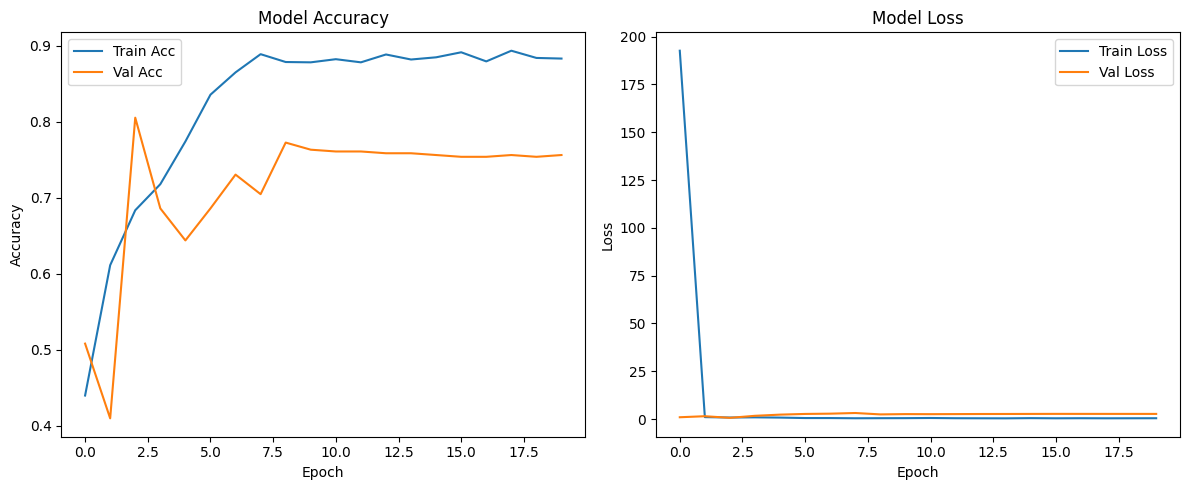

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()